In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.special import rel_entr
import seaborn as sns

In [2]:
plt.style.use('matplot.mplstyle')

# Is information from the forget set still present in the unlearned model?

### SOTA Membership Inference on unlearned model
The code below conducts the SOTA membership inference (LiRA, Carlini et al (2021)) attack on the unlearned models. As a baseline we will use the LiRA attack on train versus test points. Here, we will probe both unlearning algorithms by: 
- changing the scrubbing context on the yelp_polarity dataset (from 'vary' to one of {'ablation-rep', 'ablation-correct'})

In [3]:
''' this loads the data from the csv files'''
def get_data(model_name, nctxt, lr, mode, n, ubs, regime, context_style, dataset_name, indices):
    dfa_list = []
    for i in indices:
        if mode == 'icl':
            dfa = pd.read_csv(f'nctxt{nctxt}/results_{dataset_name}_{model_name}_model{i}_{mode}_n{n}_mepochs1_uepochs1_bs{ubs}_{context_style}_nctxt{nctxt}_{regime}.csv', index_col=False)
        else:
            dfa = pd.read_csv(f'bs{ubs}/results_{dataset_name}_{model_name}_model{i}_{mode}_n{n}_mepochs1_uepochs1_bs{ubs}_lr{lr}.csv', index_col=False)
        dfa_list.append(dfa)
    ind_mask_all = pd.read_csv(f"nctxt{nctxt}/{dataset_name}_mask_epochs1_unlearnbs{ubs}.csv", index_col=False).to_numpy()
    # ind_mask_all_extended = pd.read_csv(f"nctxt{nctxt}/{dataset_name}_extendedmask_epochs1_unlearnbs{ubs}.csv", index_col=False).to_numpy()
    return dfa_list, ind_mask_all

In [4]:
def get_losses(losses_ordered_forget, 
               losses_ordered_test, 
               ind_mask_all, 
               model_k, 
               bs):
        
    ph = []
    counter_forget = 0
    counter_test = 0
    for i in range(ind_mask_all.shape[0]):
        if ind_mask_all[i, model_k]:
            for j in range(bs):
                ph.append(losses_ordered_forget[counter_forget])
                counter_forget += 1
        else:
            for j in range(bs):
                ph.append(losses_ordered_test[counter_test])
                counter_test += 1
    return np.array(ph)

In [5]:
def get_scores(df_list_, ind_mask, indices, forget: str, test: str):
    M = len(df_list_)
    scores = np.zeros((df_list_[0].shape[0]*2, M))
    for iter_j, m_idx in enumerate(indices):
        s = get_losses(losses_ordered_forget=df_list_[iter_j][forget], 
                       losses_ordered_test=df_list_[iter_j][test],
                       ind_mask_all=ind_mask, 
                       model_k=m_idx, 
                       bs=1)
        scores[:,iter_j] = s
    return scores

In [6]:
def split_scores(scores, ind_mask_all, min_keep=3, lrt=False, idx_t0=0):
    n_keep = min_keep - 1
    if lrt:
        # overwrite this as we have one less model available
        n_keep = n_keep - 1
        M = scores.shape[1]
        # t0 data with arbitrary idx (i.e., model idx to be attacked)
        mask_t0 =  ind_mask_all[:, idx_t0]
        t0 = scores[:, idx_t0]
        # remaining data
        other_inds = np.delete(range(M), idx_t0).tolist()
        ind_mask_all = ind_mask_all[:,other_inds]
        scores = scores[:, other_inds]
        # compute ins and outs
        maskin = ind_mask_all * 1
        maskout = (~ind_mask_all) * 1
        scores_in = scores * maskin
        scores_out = scores * maskout
        # make sure to have at least min_keep
        nzi = np.zeros(scores_in.shape[0], dtype=bool)
        non_zeros_in = np.where(np.sum(maskin, axis=1) > n_keep)[0]
        nzi[non_zeros_in] = True
        nzo = np.zeros(scores_out.shape[0], dtype=bool)
        non_zeros_out = np.where(np.sum(maskout, axis=1) > n_keep)[0]
        nzo[non_zeros_out] = True
        ind_keep = np.where(((nzi*1)*(nzo*1))!=0)[0]
        # update everything
        scores_in = scores_in[ind_keep]   # update scores in
        scores_out = scores_out[ind_keep] # update scores out
        t0 = t0[ind_keep]                 # update t0
        mask_t0 = mask_t0[ind_keep]       # update mask
        # compute averages
        normalizer_in = np.count_nonzero(scores_in, axis=1)
        normalizer_out = np.count_nonzero(scores_out, axis=1)
        m_scores_unlearned = np.sum(scores_in, axis=1)/normalizer_in
        m_scores_retained = np.sum(scores_out, axis=1)/normalizer_out
        return m_scores_unlearned, m_scores_retained, t0, mask_t0
    else:
        maskin = ind_mask_all * 1
        maskout = (~ind_mask_all) * 1
        scores_in = scores * maskin
        scores_out = scores * maskout
        # make sure to have at least min_keep
        nzi = np.zeros(scores_in.shape[0], dtype=bool)
        non_zeros_in = np.where(np.sum(maskin, axis=1)>n_keep)[0]
        nzi[non_zeros_in] = True
        nzo = np.zeros(scores_out.shape[0], dtype=bool)
        non_zeros_out = np.where(np.sum(maskout, axis=1)>n_keep)[0]
        nzo[non_zeros_out] = True
        ind_keep = np.where(((nzi*1)*(nzo*1))!=0)[0]
        scores_in = scores_in[ind_keep]
        scores_out = scores_out[ind_keep]
        # averages over in/out models
        normalizer_in = np.count_nonzero(scores_in, axis=1)
        normalizer_out = np.count_nonzero(scores_out, axis=1)
        m_scores_unlearned = np.sum(scores_in, axis=1)/normalizer_in
        m_scores_retained = np.sum(scores_out, axis=1)/normalizer_out
        return m_scores_unlearned, m_scores_retained

In [7]:
def get_lrt_scores(t0, mask_t0, m_scores_unlearn_lrt, m_scores_holdout_lrt, global_var):
    # this compute lrt scores for the LiRA attack
    mean_scores_unlearn_lrt = np.mean(m_scores_unlearn_lrt)
    mean_scores_holdout_lrt = np.mean(m_scores_holdout_lrt)
    std_unlearn = np.std(m_scores_unlearn_lrt)
    std_holdout = np.std(m_scores_holdout_lrt)
    if global_var:
        overall_std_lrt = np.std(np.array([m_scores_unlearn_lrt, m_scores_holdout_lrt]))
        std_unlearn = overall_std_lrt
        std_holdout = overall_std_lrt
    pr_in_lrt = - norm.logpdf(t0, m_scores_unlearn_lrt, std_unlearn+1e-15)
    pr_out_lrt = - norm.logpdf(t0, m_scores_holdout_lrt, std_holdout+1e-15)
    scores_lrt = pr_in_lrt - pr_out_lrt 
    m_scores_unlearn_lrt = scores_lrt[mask_t0]
    m_scores_holdout_lrt = scores_lrt[~mask_t0]
    return m_scores_unlearn_lrt, m_scores_holdout_lrt

In [8]:
from sklearn import metrics
def compute_curve(train_scores: np.array, test_scores: np.array, pos_label=1):
    y = np.r_[np.ones(np.shape(train_scores)[0]), np.zeros(np.shape(test_scores)[0])]
    fs, ts, thresholds = metrics.roc_curve(y, np.r_[train_scores, test_scores], pos_label=pos_label)
    return ts, fs

In [9]:
# setup
indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
n = 12500
ubs = 1
mode = 'icl'
iters = len(indices)
global_var = False
mean_fpr = np.linspace(0, 1, 10000)
# dataset options: {'imdb', 'yelp_polarity', 'sst2', 'amazon_polarity'}
ubs = 1
regime = 'lfmfirst-k'
mode = 'icl'

### Probing the unlearning mechanism

In [10]:
dataset_name = 'sst2'
model_name = 'bloom-1b1'
if dataset_name == 'sst2' and model_name == 'bloom-1b1':
    ctxt_lengths = [2, 4, 6]
elif dataset_name == 'sst2' and model_name == 'bloom-560m':
    ctxt_lengths = [4, 6]
elif dataset_name == 'yelp_polarity':
    ctxt_lengths = [2, 4, 6]
lr = '1e-05'
context_styles = ['ablation-exchange', 'ablation-correct', 'vary']

In [11]:
''' This is to plot confidence intervals for the ROC curves '''
ablation_results = {}
# start loop [only loop over 2 & 5 as 3 and 4 give similar results. That way loop goes faster.]
for context_style in context_styles:
    print(f'context style: {context_style}')
    min_keep_results = {}
    for min_keep in [2, 5]:
        '''Here we loop over different min_keep scores which control how average results; 
           i.e., we average when we have at least >2-1<, >3-1<, >4-1<, or >5-1< observations 
           to average over)'''
        print(f'min keep: {min_keep}')
        results = {'metric_icl': {'2': {'tprs': [], 'aucs': []},
                                  '4': {'tprs': [], 'aucs': []},
                                  '6': {'tprs': [], 'aucs': []},
                                  '8': {'tprs': [], 'aucs': []}},
                    'metric_base1': {'tprs': [], 'aucs': []},
                    }
        ''' Here we loop over different models t_0 to make sure we obtain confidence intervals. 
           Since we have trained N=10 model, we can compute the stand. dev. over these 10 models. '''
        for idx_t0 in range(iters):
            print(f'iteration: {idx_t0}')
            for i, nctxt in enumerate(ctxt_lengths):
                print('Context length:', nctxt)
                dflist, ind_mask_all = get_data(model_name=model_name,
                                                nctxt=nctxt, lr=lr, mode='icl', n=n, ubs=ubs, 
                                                context_style=context_style, regime=regime,
                                                dataset_name=dataset_name, indices=indices)    

                # forget vs holdout
                scores_0 = get_scores(dflist, ind_mask_all, indices, forget='losses_icl_forget_0', test='losses_icl_test_0')
                m_scores_unlearned_lrt, m_scores_retained_lrt0, t00, mask_t00 = split_scores(scores_0, ind_mask_all, min_keep=min_keep, lrt=True, idx_t0=idx_t0)
                m_scores_unlearned_lrt, m_scores_retained_lrt0 = get_lrt_scores(t00, mask_t00, m_scores_unlearned_lrt, m_scores_retained_lrt0, global_var)

                # start collecting the meat
                ts_icl, fs_icl = compute_curve(m_scores_unlearned_lrt, m_scores_retained_lrt0, pos_label=0)
                auc_icl = np.round(metrics.auc(fs_icl, ts_icl), 2)
                interp_tpr_icl = np.interp(mean_fpr, fs_icl, ts_icl)
                interp_tpr_icl[0] = 0.0
                results['metric_icl'][str(nctxt)]['tprs'].append(interp_tpr_icl)
                results['metric_icl'][str(nctxt)]['aucs'].append(auc_icl)
            
                if i == 0:
                    # train vs holdout
                    scores_1 = get_scores(dflist, ind_mask_all, indices, forget='losses_base_forget_0', test='losses_base_test_0')
                    m_scores_forget_lrt, m_scores_retained_lrt1, t01, mask_t01 = split_scores(scores_1, ind_mask_all, min_keep=min_keep, lrt=True, idx_t0=idx_t0)
                    m_scores_forget_lrt, m_scores_retained_lrt1 = get_lrt_scores(t01, mask_t01, m_scores_forget_lrt, m_scores_retained_lrt1, global_var)

                    ''' BASELINE '''
                    ts_base1, fs_base1 = compute_curve(m_scores_forget_lrt, m_scores_retained_lrt1, pos_label=0)
                    auc_base1 = np.round(metrics.auc(fs_base1, ts_base1), 2)
                    interp_tpr_base1 = np.interp(mean_fpr, fs_base1, ts_base1)
                    interp_tpr_base1[0] = 0.0
                    results['metric_base1']['tprs'].append(interp_tpr_base1)
                    results['metric_base1']['aucs'].append(auc_base1)

        min_keep_results[f'min_keep{min_keep}'] = results
    ablation_results[context_style] = min_keep_results

context style: ablation-exchange
min keep: 2
iteration: 0
Context length: 2
Context length: 4
Context length: 6
iteration: 1
Context length: 2
Context length: 4
Context length: 6
iteration: 2
Context length: 2
Context length: 4
Context length: 6
iteration: 3
Context length: 2
Context length: 4
Context length: 6
iteration: 4
Context length: 2
Context length: 4
Context length: 6
iteration: 5
Context length: 2
Context length: 4
Context length: 6
iteration: 6
Context length: 2
Context length: 4
Context length: 6
iteration: 7
Context length: 2
Context length: 4
Context length: 6
iteration: 8
Context length: 2
Context length: 4
Context length: 6
iteration: 9
Context length: 2
Context length: 4
Context length: 6
min keep: 5
iteration: 0
Context length: 2
Context length: 4
Context length: 6
iteration: 1
Context length: 2
Context length: 4
Context length: 6
iteration: 2
Context length: 2
Context length: 4
Context length: 6
iteration: 3
Context length: 2
Context length: 4
Context length: 6
itera

In [12]:
ablation_results

{'ablation-exchange': {'min_keep2': {'metric_icl': {'2': {'tprs': [array([0.00000000e+00, 8.03148341e-05, 3.21259337e-04, ...,
             9.99839370e-01, 9.99919685e-01, 1.00000000e+00]),
      array([0.00000000e+00, 2.40963855e-04, 2.40963855e-04, ...,
             1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
      array([0.00000000e+00, 9.64397653e-04, 1.12513060e-03, ...,
             9.99919634e-01, 9.99919634e-01, 1.00000000e+00]),
      array([0.00000000e+00, 3.21983418e-04, 4.02479272e-04, ...,
             1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
      array([0.00000000e+00, 8.03600129e-05, 5.62520090e-04, ...,
             9.99919640e-01, 1.00000000e+00, 1.00000000e+00]),
      array([0.00000000e+00, 3.21285141e-04, 4.01606426e-04, ...,
             1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
      array([0.00000000e+00, 4.82005141e-04, 7.23007712e-04, ...,
             1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
      array([0.00000000e+00, 6.42673

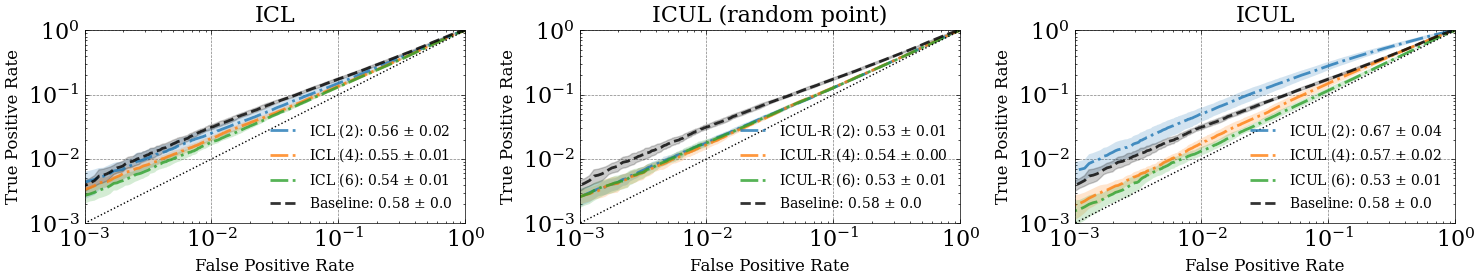

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(3*5, 3))
savingtype = 'pdf'
min_keep = '2'
lr = '1e-05'
context_styles = ['ablation-correct', 'ablation-exchange', 'vary']
context_style_name = ['ICL', 'ICUL (random point)', 'ICUL']
for id_context, context_style in enumerate(context_styles):
    results = ablation_results[context_style][f'min_keep{min_keep}']
    for i, nctxt in enumerate(ctxt_lengths):
        '''ICUL'''
        tprs_u = np.array(results['metric_icl'][f'{nctxt}']['tprs']).T
        aucs_u = np.array(results['metric_icl'][f'{nctxt}']['aucs']).T
        mean_tpr_u = np.mean(tprs_u, axis=1)
        std_tpr_u = np.std(tprs_u, axis=1)
        mean_tpr_u[-1] = 1.0
        mean_auc_u = np.mean(aucs_u).round(2)
        std_auc_u = np.std(aucs_u).round(2)
        
        # Unlearn vs Holdout
        if id_context == 0:
            l = 'ICL'
        elif id_context == 1:
            l = 'ICUL-R'
        else: 
            l = 'ICUL'
        axs[id_context].loglog(mean_fpr, mean_tpr_u,
                               label=f"{l} ({nctxt}): %0.2f $\pm$ %0.2f" % (mean_auc_u, std_auc_u), 
                               lw=2, alpha=0.8, linestyle='dashdot')
        tprs_upper_u = mean_tpr_u + std_tpr_u #np.minimum(mean_tpr_u + std_tpr_u, 1)
        tprs_lower_u = mean_tpr_u - std_tpr_u #np.maximum(mean_tpr_u - std_tpr_u, 0)
        axs[id_context].fill_between(mean_fpr, tprs_lower_u, tprs_upper_u, alpha=0.2)

    ''' BASELINES '''
    tprs_b = np.array(results[f'metric_base1']['tprs']).T
    aucs_b = np.array(results[f'metric_base1']['aucs']).T
    mean_tpr_b = np.mean(tprs_b, axis=1)
    std_tpr_b = np.std(tprs_b, axis=1)
    mean_tpr_b[-1] = 1.0
    mean_auc_b = np.mean(aucs_b).round(2)
    std_auc_b = np.std(aucs_b).round(2)
    label = 'Baseline' #'Train v. Holdout'
    axs[id_context].loglog(mean_fpr, mean_tpr_b, 
                        label=f"{label}: {mean_auc_b} $\pm$ {std_auc_b}", 
                        lw=2, alpha=0.8, linestyle='dashed', color='black')
    tprs_upper_b = np.minimum(mean_tpr_b + std_tpr_b, 1)
    tprs_lower_b = np.maximum(mean_tpr_b - std_tpr_b, 0)
    axs[id_context].fill_between(mean_fpr, tprs_lower_b, tprs_upper_b, alpha=0.2, color='black') #label=r"$\pm$ 1 std. dev.")
    axs[id_context].plot([0,1], [0,1], linestyle='dotted', color='black', lw=1.0)

    axs[id_context].legend(loc=4)
    axs[id_context].set_xlabel('False Positive Rate', fontsize=12)
    axs[id_context].set_ylabel('True Positive Rate', fontsize=12)
    axs[id_context].set_xlim([0.001, 1])
    axs[id_context].set_ylim([0.001, 1])
    axs[id_context].set_title(context_style_name[id_context])
plt.tight_layout()
plt.savefig(f'results_ubs1/info_extraction_probing_loglog_{model_name}_{mode}_ubs{ubs}_{regime}_{dataset_name}_minkeep{min_keep}.{savingtype}')